# Classification d'images : Partie 1, la méthode old school

## Sujet de cette partie

Cette partie, la Partie 1, consiste à extraire des attributs (primitives) classiquement utilisés en traitement d’image, comme la couleur, la texture, etc., et de procéder à une classification d’image s’appuyant sur des critères de décision simples, basés sur les distances entre vecteurs d’attributs.

## Le code de base

Ici, pour l'approche old school, nous nous basons sur le code sur ce dépôt :
https://github.com/pochih/CBIR/

Ce dépôt contient un système CBIR (Content Based Image Retrieval). Le but de ce système est d'extraire les caractéristiques des images pour les classer.

Ci-dessous un schéma du fonctionnement du système CBIR :

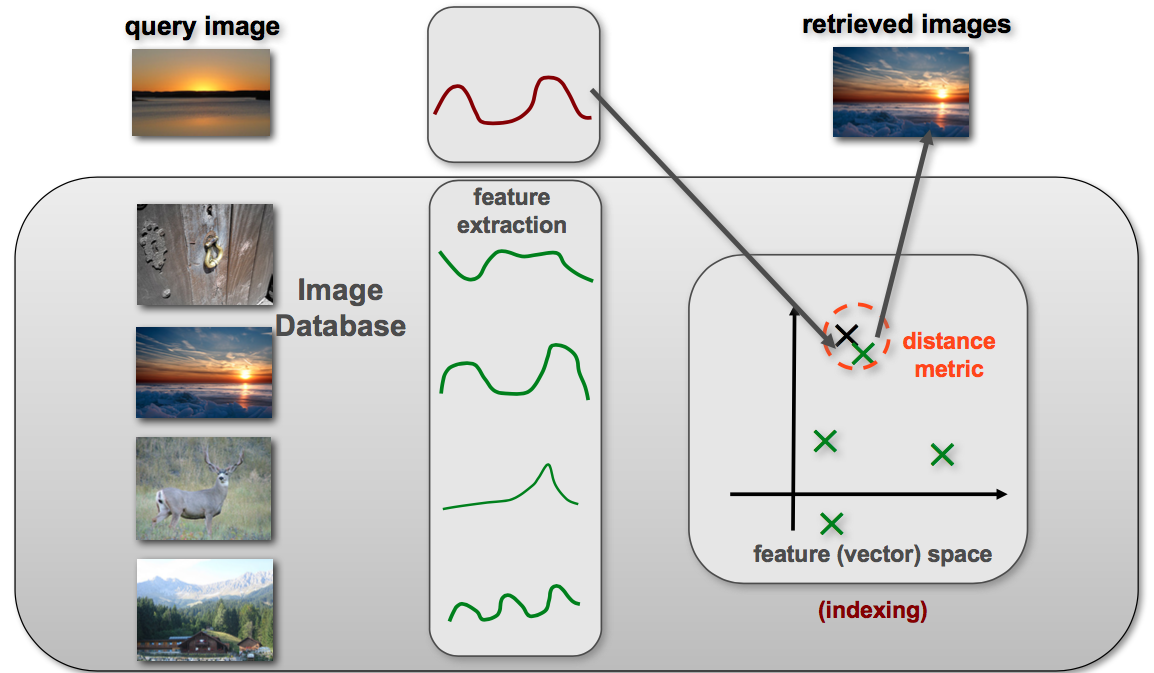

Voici l'arborescence du projet :

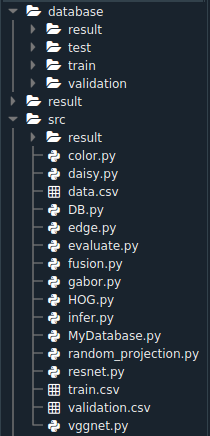

Dans le dossier "Database", vous pouvez retrouver la base de données d'images utilisée pour l'apprentissage avec les dossiers "train", "test" et "validation". Le dossier "result" contiendra le résultat d'une exécution où le système essaiera de reclasser les images dans les bonnes classes en fonction de la méthode utilisée.

Le dossier "src", quant à lui, contient les différentes méthodes de comparaison ainsi que des fichiers utilitaires.

Il existe plusieurs méthodes de comparaison, dont par exemple :
<ul>
    <li>color.py : fichier utilisé dans ce projet, il permet de classer les images en fonction de leurs couleurs ;</li>
    <li>edge.py : se base sur les formes ;</li>
    <li>hog.py : se base sur l'histogramme de Gradient ;</li>
    <li>...</li>
</ul>

Ces méthodes de comparaison utilisent toutes les fichiers "evaluate.py" et "DB.py".<br>
Le fichier "DB.py" contient la classe Database qui prend en argument le csv qui représente la base de données des images ainsi que le dossier qui la contient. Ce fichier permet de récupérer les données.<br>
Le fichier "evaluate.py", quant à lui, contient des méthodes pour évaluer les images.

## Les données

La base de données d'images que nous avons utilisé est CorelDB :
https://sites.google.com/site/dctresearch/Home/content-based-image-retrieval?fbclid=IwAR1PY1wmr60LKzcW6PRWTuug_nK41ipgT4qdGH7yA44aJT8MBEtqSXzNmSE <br>
Cette base est composée de 10 800 images issues de la Corel Photo Gallery et classées en différentes catégories.

Pour ce projet, j'ai utilisé 6 classes comportant au total 367 images dans le dossier train et 347 images dans le dossier validation.

Les classes sont :
<ul>
    <li>bld_sculpt : des images représentant des sculptures ;</li>
    <li>obj_234000 : des objets qui ressemble à un visage humain ou animal, assez colorés ;</li>
    <li>obj_eastregg : des oeufs ;</li>
    <li>sc_cloud : des photos de nuages dont certains sont colorés ;</li>
    <li>sc_iceburg : des photos d'icebergs ;</li>
    <li>wl_cat : des images de chats.</li>
</ul>

Vous pourrez trouver le code dans la suite de cette page :

## Imports

In [28]:
from __future__ import print_function
from sklearn.utils.extmath import weighted_mode
from scipy import spatial
from six.moves import cPickle

import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
import statistics
import collections
import itertools
import imageio
import matplotlib.image as mpimg

## Database

Cette classe permet de récupérer les images. Elle prend en argument le dossier contenant les images <b>DB_dir</b> et l'emplacement du fichier CSV qui contiendra les informations sur cette base <b>DB_csv</b>.

Passer ces paramètres permet de créer plusieurs objets MyDatabase faisant référence à des sets d'images différents, ce qui permet, dans nôtre cas, d'avoir un jeu <b>train</b> et un jeu <b>validation</b>. En effet, le code fourni sur GitHub n'avait pas de paramètres dans le constructeur de cette classe, ce qui empêchait d'avoir différents jeux de données.

In [29]:
class MyDatabase(object):
    def __init__(self, DB_dir, DB_csv):
        self._gen_csv(DB_dir, DB_csv)
        self.data = pd.read_csv(DB_csv)
        self.classes = set(self.data["cls"])
        self.db_type = DB_dir[-4:]

    def _gen_csv(self, DB_dir, DB_csv):
        if os.path.exists(DB_csv):
            return
        with open(DB_csv, 'w', encoding='UTF-8') as f:
            f.write("img,cls")
            for root, _, files in os.walk(DB_dir, topdown=False):
                cls = root.split('/')[-1] # \\ ?
                for name in files:
                    if not name.endswith('.jpg'):
                        continue
                    img = os.path.join(root, name)
                    f.write("\n{},{}".format(img, cls))

    def __len__(self):
        return len(self.data)

    def get_class(self):
        return self.classes

    def get_data(self):
        return self.data

    def get_db_type(self):
        return self.db_type

## La classe Evaluation

Cette classe permet d'évaluer les images.

Pour ce projet, j'ai du modifier plusieurs méthodes dans cette classe :

### myAP

À l'origine, il y avait une méthode appelée <b>AP</b>. Cette méthode permettait de trouver les images qui ressemblent à l'image d'entrée.</br>
J'ai modifié cette fonction et l'ai renommée en <b>myAP</b> pour que celle-ci, au lieu de trouver les images les plus proches, classe l'image en entrée dans la classe correspondante.

Le fonctionnement est simple : dans le cas ou une image ressemble à l'image d'entrée, on met la variable <b>hit à 1</b> et on l'ajoute à la liste <i>precision</i>, sinon on la <b>laisse à 0</b>. </br>
Une fois toutes les images traitées (sortie de la boucle for), on fait la moyenne des précisions. Si la moyenne est <b>supérieure à 0.5</b>, cela veut dire que la plupart des images ont été bien triées, et donc on renvoie True. Si ce n'est pas le cas, on renvoie False.

### infer

La but de la fonction infer est de récupérer les images, extraire leurs caractéristiques et récupérer les images les plus proches.</br>
Avant mes modifications, la fonction infer se basait uniquement sur la distance entre deux images pour déterminer leur similarité.</br>
La fonction se base maintenant sur la <b>distance</b> et la <b>classe</b> de l'image. 

### myevaluate

La fonction myevaluate parcourt toutes les images et fait appel à infer sur chacune d'elle pour récupérer la prédiction. À l'origine, la classe myevaluate s'appelait evaluate et ne gérait qu'une seule base d'images. J'ai modifié cela pour qu'elle prenne en charge <b>deux bases d'images</b> (représentant train et validation).

In [30]:
class Evaluation(object):
    def make_samples(self):
        raise NotImplementedError("Needs to implemented this method")


    def distance(v1, v2, d_type='d1'):
        assert v1.shape == v2.shape, "shape of two vectors need to be same!"

        if d_type == 'd1':
            return np.sum(np.absolute(v1 - v2))
        elif d_type == 'd2':
            return np.sum((v1 - v2) ** 2)
        elif d_type == 'd2-norm':
            return 2 - 2 * np.dot(v1, v2)
        elif d_type == 'd3':
            pass
        elif d_type == 'd4':
            pass
        elif d_type == 'd5':
            pass
        elif d_type == 'd6':
            pass
        elif d_type == 'd7':
            return 2 - 2 * np.dot(v1, v2)
        elif d_type == 'd8':
            return 2 - 2 * np.dot(v1, v2)
        elif d_type == 'cosine':
            return spatial.distance.cosine(v1, v2)
        elif d_type == 'square':
            return np.sum((v1 - v2) ** 2)


    def myAP(label, results, sort=True):
        ''' infer a query, return it's ap

            arguments
                label  : query's class
                results: a dict with two keys, see the example below
                       {
                         'dis': <distance between sample & query>,
                         'cls': <sample's class>
                       }
                sort   : sort the results by distance
        '''
        if sort:
            results = sorted(results, key=lambda x: x['dis'])
        precision = []
        hit = 0
        for i, result in enumerate(results):
            hit = 0.  
            if result['cls'] == label:
                hit = 1.
                precision.append(hit)

        return (np.mean(precision)>0.5)

    def infer(query, samples=None, db=None, sample_db_fn=None, depth=None, d_type='d1'):
        ''' infer a query, return it's ap
            arguments
                query       : a dict with three keys, see the template
                            {
                                'img': <path_to_img>,
                                'cls': <img class>,
                                'hist' <img histogram>
                            }
                samples     : a list of 
                            {
                                'img': <path_to_img>,
                                'cls': <img class>,
                                'hist' <img histogram>
                            }
                db          : an instance of class Database
                sample_db_fn: a function making samples, should be given if Database != None
                depth       : retrieved depth during inference, the default depth is equal to database size
                d_type      : distance type
        '''
        assert samples != None or (db != None and sample_db_fn != None), "need to give either samples or db plus sample_db_fn"
        if db:
            samples = sample_db_fn(db)

        q_img, q_cls, q_hist = query['img'], query['cls'], query['hist']
        results = []
        for idx, sample in enumerate(samples):
            s_img, s_cls, s_hist = sample['img'], sample['cls'], sample['hist']
            if q_img == s_img:
                continue
            results.append({
                'dis': Evaluation.distance(q_hist, s_hist, d_type=d_type),
                'cls': s_cls,
                'img': s_img
            })
        results = sorted(results, key=lambda x: x['dis'])
        if depth and depth <= len(results):
            results = results[:depth]
            list_im = [sub['img'] for sub in results]
            list_im.insert(0, q_img)
            pred = [sub['cls'] for sub in results]
            weig = [sub['dis'] for sub in results]
            weig = np.reciprocal(weig)
            # pred = statistics.mode(pred)
            pred2 = weighted_mode(pred, weig)
            pred = np.array_str(pred2[0])[2:-2]
            # pred = collections.Counter(pred).most_common(1)

            # imgs = [PIL.Image.open(i) for i in list_im]
            # min_shape = sorted([(np.sum(i.size), i.size) for i in imgs])[0][1]
            # imgs_comb = np.hstack((np.asarray(i.resize(min_shape)) for i in imgs))
            # plt.imshow(imgs_comb/255.)
            # plt.pause(0.1)
            # plt.close()
        
        #ap = AP(q_cls, results, sort=False)
        ap = Evaluation.myAP(q_cls, results, sort=False)

        # return ap, results
        return ap, pred

    def myevaluate(db1, db2, sample_db_fn, depth=None, d_type='d1'):
        ''' infer the whole database

            arguments
                db          : an instance of class Database
                sample_db_fn: a function making samples, should be given if Database != None
                depth       : retrieved depth during inference, the default depth is equal to database size
                d_type      : distance type
        '''
      
        samples2 = sample_db_fn(db2)
        print(len(samples2))

        samples1 = sample_db_fn(db1)
        print(len(samples1))

        classes = db1.get_class()
        classes.add(samples2[0]["cls"])

        ret = {c: [] for c in classes}

        i = 0
        predict = []
      
        for query in samples2:
            i+=1
            ap, pred = Evaluation.infer(query, samples=samples1, depth=depth, d_type=d_type)
            ret[query['cls']].append(ap)
            predict.append(pred)

        return ret, predict

## La classe Color

La classe Color est utilisée pour <b>extraire les attributs des images</b>. Ici, comme son nom l'indique, on extrait les attributs de couleurs.

In [31]:
# configs for histogram
n_bin = 12  # histogram bins
n_slice = 3  # slice image
h_type = 'region'  # global or region
d_type = 'd1'  # distance type

depth = 4  # retrieved depth, set to None will count the ap for whole database

class Color(object):
    def histogram(self, input, n_bin=n_bin, type=h_type, n_slice=n_slice, normalize=True):
        if isinstance(input, np.ndarray):  # examinate input type
            img = input.copy()
        else:
            img = imageio.imread(input)
        height, width, channel = img.shape
        bins = np.linspace(0, 256, n_bin + 1, endpoint=True)  # slice bins equally for each channel

        if type == 'global':
            hist = self._count_hist(img, n_bin, bins, channel)

        elif type == 'region':
            hist = np.zeros((n_slice, n_slice, n_bin ** channel))
            h_silce = np.around(np.linspace(0, height, n_slice + 1, endpoint=True)).astype(int)
            w_slice = np.around(np.linspace(0, width, n_slice + 1, endpoint=True)).astype(int)

            for hs in range(len(h_silce) - 1):
                for ws in range(len(w_slice) - 1):
                    img_r = img[h_silce[hs]:h_silce[hs + 1], w_slice[ws]:w_slice[ws + 1]]  # slice img to regions
                    hist[hs][ws] = self._count_hist(img_r, n_bin, bins, channel)

        if normalize:
            hist /= np.sum(hist)

        return hist.flatten()

    def _count_hist(self, input, n_bin, bins, channel):
        img = input.copy()
        bins_idx = {key: idx for idx, key in
                    enumerate(itertools.product(np.arange(n_bin), repeat=channel))}  # permutation of bins
        hist = np.zeros(n_bin ** channel)

        # cluster every pixels
        for idx in range(len(bins) - 1):
            img[(input >= bins[idx]) & (input < bins[idx + 1])] = idx
        # add pixels into bins
        height, width, _ = img.shape
        for h in range(height):
            for w in range(width):
                b_idx = bins_idx[tuple(img[h, w])]
                hist[b_idx] += 1

        return hist

    def make_samples(self, db, verbose=True):
        mystr = db.get_db_type()
      
        if h_type == 'global':
            sample_cache = "histogram_cache-{}-n_bin{}_{}".format(h_type, n_bin, mystr)
        elif h_type == 'region':
            sample_cache = "histogram_cache-{}-n_bin{}-n_slice{}_{}".format(h_type, n_bin, n_slice, mystr)

        if verbose:
            print("Counting histogram..., config=%s, distance=%s, depth=%s" % (sample_cache, d_type, depth))
        samples = []
        data = db.get_data()
        for d in data.itertuples():
            d_img, d_cls = getattr(d, "img"), getattr(d, "cls")
            d_hist = self.histogram(d_img, type=h_type, n_bin=n_bin, n_slice=n_slice)
            samples.append({
                'img': d_img,
                'cls': d_cls,
                'hist': d_hist
            })

        return samples


## Main code

C'est le code qui lance l'application et résupère les résultats. Plusieurs modifications ont été apportées ici.

Tout d'abord, nous avons maintenant deux bases de données : une pour les images utilisées pour l'entraînement et une pour la validation. Ces deux bases de données sont instanciées ici avec les différents paramètres : <b>DB_train_dir, DB_train_csv, DB_validation_dir, DB_validation_csv</b>.

Ensuite, on fait appel à la méthode custom <i>myevaluate</i> pour évaluer nos images et les traiter en fonction de ses attributs couleur.

Les résultats de myevaluate sont ensuite stockés dans <b>APs</b> et <b>res</b>. Ces résultats correspondent aux informations sur les classes prédites pour APs et aux images les plus proches de chaque image dans res.

Grâce à ces variables, on peut <b>récupérer différentes statistiques</b> sur les prédictions comme sa précision que l'on va afficher : la précision par classe et la précision globale sur toutes les classes.

Enfin, la dernière boucle for permet de ranger les images dans un dossier de résultat pour avoir le classement accessible dans le dossier <i>"./data/resultCBIR/</i>.

In [32]:
if __name__ == "__main__":
    if os.path.exists("./csv/train.csv"):
        os.remove("./csv/train.csv")
        print("Removed train.csv")
    if os.path.exists("./csv/validation.csv"):
        os.remove("./csv/validation.csv")
        print("Removed validation.csv")
    
    # On vide les dossiers résultat pour préparer à l'exécution
    print("Suppression des résultats des exécutions précédentes")
    repertoire = "./data/resultCBIR"
    for classe in os.listdir(repertoire) :
        for filename in os.listdir(repertoire + "/" + classe) :
            os.remove(repertoire + "/" + classe + "/" + filename)

    print()

    DB_train_dir = './data/train'
    DB_train_csv = './csv/train.csv'

    db1 = MyDatabase(DB_train_dir, DB_train_csv)

    color = Color()

    DB_validation_dir = './data/validation'
    DB_validation_csv = './csv/validation.csv'

    db2 = MyDatabase(DB_validation_dir, DB_validation_csv)

    # Evaluate database
    APs, res = Evaluation.myevaluate(db1, db2, color.make_samples, depth=depth, d_type='d1')
    
    cls_MAPs = []
    
    for cls, cls_APs in APs.items():
        MAP = np.mean(cls_APs)
        print("Class {}, MAP {}".format(cls, MAP))
        cls_MAPs.append(MAP)
    print("MMAP", np.mean(cls_MAPs))

    for i in range(len(db2)):
        saveName = "./data/resultCBIR/" + res[i] + "/" + db2.data.img[i].split("/")[-1]
        bid = imageio.imread(db2.data.img[i])
        mpimg.imsave(saveName, bid/255.)


Removed train.csv
Removed validation.csv
Suppression des résultats des exécutions précédentes

Counting histogram..., config=histogram_cache-region-n_bin12-n_slice3_tion, distance=d1, depth=4
367
Counting histogram..., config=histogram_cache-region-n_bin12-n_slice3_rain, distance=d1, depth=4
347
Class wl_cat, MAP 0.8727272727272727
Class sc_cloud, MAP 0.9272727272727272
Class bld_sculpt, MAP 0.9150943396226415
Class obj_234000, MAP 0.9818181818181818
Class sc_iceburg, MAP 0.8363636363636363
Class obj_eastregg, MAP 1.0
MMAP 0.9222126929674098


## Conclusion

Avec cette méthode, la méthode Old School, nous avons pu voir comment traiter des images en fonction de l'extraction de leurs attributs, tel que leur couleur dans nôtre cas. D'autres techniques étaient aussi possibles comme les contours ou la texture par exemple, il aurait été intéressant de tester aussi ces méthodes pour comparer les résultats avec le classement par couleur.</br>
Nous avons pu voir que les résultats sont plutôt bon dans le cas de l'extraction d'attributs de couleur comme l'atteste la capture ci-dessous (moyenne de 0.92) :

